In [1]:
!nvidia-smi -L
import os

os.environ["CUDA_VISIBLE_DEVICES"]="MIG-00992b28-9de1-5e60-993b-b31261914ee9"

GPU 0: NVIDIA A30 (UUID: GPU-ba0bbb2e-4b3a-7fd3-9f30-20e806ac6473)
  MIG 2g.12gb     Device  0: (UUID: MIG-4c6deb33-4c3f-5990-89bf-891bd00dac17)
  MIG 2g.12gb     Device  1: (UUID: MIG-49cf492b-2f3d-5fdd-9d3d-8f06f9ed2168)
GPU 1: NVIDIA A30 (UUID: GPU-ab2d9375-73c4-474a-3dd1-a6486d253e86)
  MIG 2g.12gb     Device  0: (UUID: MIG-378f61ad-ac06-54f7-a83e-dd911963df33)
  MIG 2g.12gb     Device  1: (UUID: MIG-00992b28-9de1-5e60-993b-b31261914ee9)


In [2]:
from datasets import load_dataset
from PIL import Image

IRFL_images = load_dataset("lampent/IRFL", data_files='IRFL_images.zip')['train']

/home/gusfilvi@GU.GU.SE/.conda/envs/AICS/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# functions for local run borrowed from https://colab.research.google.com/drive/1RfcUhBTHvREx5X7TMY5UAgMYX8NMKy7u?usp=sharing#scrollTo=EGj78A5X8PUp 

def get_image_path_from_folder(image_name):
  image_folder_path = r'C:\devel\IRLM\assets\D_images'
  return f'{image_folder_path}\\{image_name.split(".")[0] + ".jpeg"}'

def get_image_path_from_hugginface_cache(image_name):
    chached_image_path = IRFL_images[0]['image'].filename
    chached_image_name = chached_image_path.split('/')[-1]
    return chached_image_path.replace(chached_image_name, image_name.split('.')[0] + '.jpeg')

In [4]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

import matplotlib.pyplot as plt
from transformers import BertTokenizerFast

import pandas as pd
import numpy

tokenizer = BertTokenizerFast.from_pretrained("bert-base-uncased")

batch_size = 64
lr = 0.0001
device =  torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [5]:
from image_processing import ImageProcessor

class Multimodal_Dataset(Dataset):
    def __init__(self, data, tokenizer):
        data = pd.read_csv(data)
        self.phrases = data['phrase']
        self.images = data['image']
        self.labels = data['category']

        self.tokenizer = tokenizer
        self.visual_extractor = ImageProcessor(device='cuda')

        self.categories = set(list(self.labels))

    def __len__(self):
        return len(self.phrases)

    def __getitem__(self, idx):

        encodings = self.tokenizer.encode_plus(self.phrases[idx],
                                          add_special_tokens=True,
                                          max_length=12,
                                          padding='max_length',
                                          truncation=True,
                                          return_tensors='pt')

        image = self.images[idx]

        if self.labels[idx] == 'Figurative' or self.labels[idx] == 'Figurative+Literal':
            label = 0
        else:
            label = 1
        
        one_hot_label = F.one_hot(torch.tensor(label), 2)

        img = get_image_path_from_hugginface_cache(image)

        embeddings, boxes = self.visual_extractor.get_visual_embeddings(img)

        item = {'phrase': self.phrases[idx],
                'input_ids': encodings['input_ids'],
                'attn_mask': encodings['attention_mask'],
                'token_type_ids': encodings['token_type_ids'],
                'image': image,
                'visual_embeddings': embeddings,
                'bboxes': boxes,
                'type': one_hot_label}
        return item

In [6]:
dataset = Multimodal_Dataset('data/random_idiom_data_filtered.csv', tokenizer)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

for batch in dataloader:
    print(batch['bboxes'])
    break

loading configuration file cache
loading weights file https://cdn.huggingface.co/unc-nlp/frcnn-vg-finetuned/pytorch_model.bin from cache at /home/gusfilvi@GU.GU.SE/.cache/torch/transformers/57f6df6abe353be2773f2700159c65615babf39ab5b48114d2b49267672ae10f.77b59256a4cf8343ae0f923246a81489fc8d82f98d082edc2d2037c977c0d9d0
All model checkpoint weights were used when initializing GeneralizedRCNN.

All the weights of GeneralizedRCNN were initialized from the model checkpoint at unc-nlp/frcnn-vg-finetuned.
If your task is similar to the task the model of the checkpoint was trained on, you can already use GeneralizedRCNN for predictions without further training.


/home/gusfilvi@GU.GU.SE/.conda/envs/AICS/lib/python3.12/site-packages/torch/functional.py:507: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3549.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


tensor([[[[4.1856e+02, 3.3235e+02, 5.5292e+02, 4.9968e+02],
          [2.1098e+02, 2.5798e+02, 7.0552e+02, 9.9518e+02],
          [9.8161e+00, 4.9629e+00, 7.2089e+02, 3.3172e+02],
          ...,
          [3.1800e+01, 3.2728e+02, 8.3114e+02, 8.9238e+02],
          [4.1788e+01, 2.1435e+02, 5.1194e+02, 1.0374e+03],
          [3.0373e+02, 4.1740e+01, 9.2853e+02, 7.0890e+02]]],


        [[[2.3151e+02, 0.0000e+00, 3.5896e+02, 1.1042e+02],
          [3.9395e+01, 1.0069e+02, 2.7546e+02, 2.1708e+02],
          [1.0778e+02, 1.0272e+02, 2.9226e+02, 2.3294e+02],
          ...,
          [1.3831e-01, 1.8972e+02, 1.3255e+02, 2.3326e+02],
          [7.3334e+01, 1.1905e+02, 2.4632e+02, 1.6786e+02],
          [7.3902e+01, 1.3496e+02, 2.4578e+02, 1.8799e+02]]],


        [[[1.0189e+02, 3.2895e+01, 2.2491e+02, 1.6559e+02],
          [7.0503e+01, 4.2942e+01, 1.9676e+02, 1.6600e+02],
          [9.0619e+01, 5.4306e+00, 1.9517e+02, 1.6434e+02],
          ...,
          [5.4123e+01, 1.3428e+00, 1.5584e+02, 

In [7]:
from tqdm import tqdm
from model import VISUAL_BERT
from transformers import get_linear_schedule_with_warmup

model = VISUAL_BERT(num_labels=2).to(device)
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

In [7]:
def split_dataset(csv_file):

    file = pd.read_csv(csv_file)

    print("total words:",len(file))
    randomized_data = file.sample(frac=1, random_state=42)
    print("total randomized words:",len(randomized_data))

    train = int(len(randomized_data) * 0.8)

    train_data = randomized_data[:train]
    print("total training set before validation split:",len(train_data))

    # val = int(len(train_data) * 0.8)
    # training_data = train_data[:val]
    # print("total training set after validation split:",len(training_data))

    # val_data = train_data[val:]
    # print("total validation set:",len(val_data))

    test_data = randomized_data[train:]
    print("total testing set:",len(test_data))

    train_filepath = "data/train_dataset.csv"
    #val_path = "data/validation_dataset.csv"
    test_filepath = "data/test_dataset.csv"
    train_data.to_csv(train_filepath, index=False)
    #val_data.to_csv(val_path, index=False)
    test_data.to_csv(test_filepath, index=False)

split_dataset('data/random_simile_data.csv')

total words: 3138
total randomized words: 3138
total training set before validation split: 2510
total testing set: 628


In [8]:
train_data = Multimodal_Dataset('data/train_dataset.csv', tokenizer=tokenizer)
test_data = Multimodal_Dataset('data/test_dataset.csv', tokenizer=tokenizer)

loading configuration file cache
loading weights file https://cdn.huggingface.co/unc-nlp/frcnn-vg-finetuned/pytorch_model.bin from cache at /home/gusfilvi@GU.GU.SE/.cache/torch/transformers/57f6df6abe353be2773f2700159c65615babf39ab5b48114d2b49267672ae10f.77b59256a4cf8343ae0f923246a81489fc8d82f98d082edc2d2037c977c0d9d0
All model checkpoint weights were used when initializing GeneralizedRCNN.

All the weights of GeneralizedRCNN were initialized from the model checkpoint at unc-nlp/frcnn-vg-finetuned.
If your task is similar to the task the model of the checkpoint was trained on, you can already use GeneralizedRCNN for predictions without further training.
loading configuration file cache
loading weights file https://cdn.huggingface.co/unc-nlp/frcnn-vg-finetuned/pytorch_model.bin from cache at /home/gusfilvi@GU.GU.SE/.cache/torch/transformers/57f6df6abe353be2773f2700159c65615babf39ab5b48114d2b49267672ae10f.77b59256a4cf8343ae0f923246a81489fc8d82f98d082edc2d2037c977c0d9d0
All model checkpoi

In [9]:
train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

In [12]:
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.9)
warmup_steps = 50
epochs = 12
total_steps = len(train_dataloader) * epochs
scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps=warmup_steps,
                                            num_training_steps=total_steps)

In [13]:
from tqdm import tqdm

model.train()

losses_train = []

for epoch in tqdm(range(epochs)):
    total_loss = 0
    for i, batch in enumerate(train_dataloader):
        input_ids = torch.LongTensor(batch['input_ids']).to(device)
        attn_masks = torch.Tensor(batch['attn_mask']).float().to(device)
        
        token_type_ids = torch.LongTensor(batch['token_type_ids']).to(device)

        visual_embeddings = torch.FloatTensor(batch['visual_embeddings']).to(device)

        visual_embeddings = visual_embeddings.squeeze().to(device)

        gold_label = batch['type'].to(device)
        attentions, outputs = model(input_ids.squeeze(1), attn_masks.squeeze(1), token_type_ids.squeeze(1), visual_embeddings)

        loss = loss_fn(outputs, gold_label.float())
        total_loss += loss.item()

        print("epoch:", epoch+1, "loss:", total_loss/(i+1), end='\r')

        loss.backward()

        optimizer.step()
        scheduler.step()

        optimizer.zero_grad()

    average_loss = total_loss / len(train_dataloader)
    losses_train.append(average_loss)

  0%|          | 0/12 [00:00<?, ?it/s]/home/gusfilvi@GU.GU.SE/.conda/envs/AICS/lib/python3.12/site-packages/torch/functional.py:507: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3549.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


  8%|▊         | 1/12 [05:02<55:26, 302.43s/it]

 17%|█▋        | 2/12 [09:32<47:12, 283.24s/it]

 25%|██▌       | 3/12 [14:02<41:34, 277.20s/it]

 33%|███▎      | 4/12 [18:32<36:35, 274.42s/it]

 42%|████▏     | 5/12 [23:02<31:51, 273.01s/it]

 50%|█████     | 6/12 [27:31<27:09, 271.62s/it]

 58%|█████▊    | 7/12 [32:00<22:33, 270.69s/it]

 67%|██████▋   | 8/12 [36:29<18:00, 270.03s/it]

 75%|███████▌  | 9/12 [40:57<13:28, 269.59s/it]

 83%|████████▎ | 10/12 [45:26<08:58, 269.45s/it]

 92%|█████████▏| 11/12 [49:55<04:29, 269.29s/it]

100%|██████████| 12/12 [54:24<00:00, 272.07s/it]

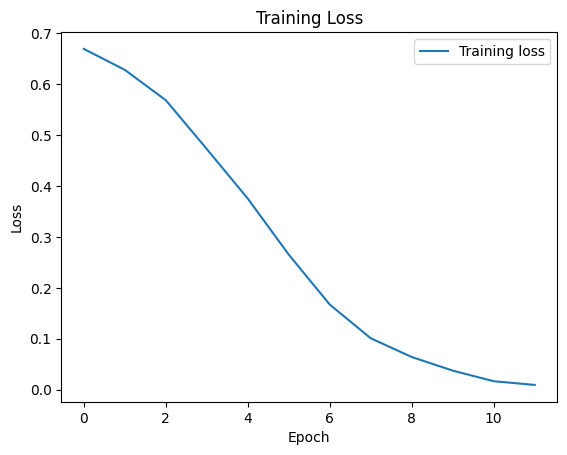

In [14]:
plt.plot(range(epochs), losses_train, label='Training loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()
plt.show()

In [10]:
def save_model(name):
    torch.save(model, name)
    print(f'{name} saved!')

def load_model(model_name):
    model_loaded = torch.load(model_name)
    print(f"{model_name} loaded!")
    return model_loaded


In [11]:
#save_model('random_simile_model.model')

In [12]:
loaded_model = load_model('random_simile_model.model')

random_simile_model.model loaded!


In [13]:
from tqdm import tqdm
loaded_model.eval()

gold_labels = []
predictions = []
outputs_dictionaries = []

with torch.no_grad():
    for i, batch in tqdm(enumerate(test_dataloader)):
        input_ids = torch.LongTensor(batch['input_ids']).to(device)
        attn_masks = torch.Tensor(batch['attn_mask']).float().to(device)
        token_type_ids = torch.LongTensor(batch['token_type_ids']).to(device)

        visual_embeddings = torch.FloatTensor(batch['visual_embeddings']).to(device)
        visual_embeddings = visual_embeddings.squeeze()
        gold_label = batch['type'].to(device)

        attentions, outputs = loaded_model(input_ids.squeeze(1), attn_masks.squeeze(1), token_type_ids.squeeze(1), visual_embeddings)

        gold_labels.extend(gold_label.cpu().numpy())

        _, predicted_labels = torch.max(outputs, dim=1)

        predictions.extend(predicted_labels.cpu().numpy())

        outputs_dictionary = {
            'batch': i,
            'phrases': batch['phrase'],
            'images': batch['image'],
            # extracting the last layer's attention weights 
            'attention_weights': attentions,
            'bboxes': batch['bboxes'],
            'ids': input_ids
        }
        
        outputs_dictionaries.append(outputs_dictionary)

gold_labels = numpy.array(gold_labels)
predictions = numpy.array(predictions)

10it [01:09,  6.93s/it]


In [21]:
visual_embeddings.shape

torch.Size([52, 1, 12])

In [14]:
from sklearn.metrics import classification_report

report = classification_report(numpy.argmax(gold_labels, axis=1), predictions, target_names=['Figurative', 'Non Figurative'])

print("Classification Report:")
print(report)

Classification Report:
                precision    recall  f1-score   support

    Figurative       0.79      0.82      0.81       234
Non Figurative       0.89      0.87      0.88       394

      accuracy                           0.85       628
     macro avg       0.84      0.85      0.84       628
  weighted avg       0.85      0.85      0.85       628

